In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Importing model, weights and transformations

In [3]:
from torchvision import models
resnet_weights = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=resnet_weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Take the transformations expected from the resnet model for usage when loading the new dataset.

**FRAGE: Ist das alles was notwendig ist damit die Bilder im richtigen Format vorliegen?**

In [4]:
preprocess = resnet_weights.transforms()
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
preprocessB = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
preprocessB

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Load the dataset with the required preprocessing steps.

# Importing caltech256

In [ ]:
caltech256 = datasets.Caltech256(
    root="data",
    download=True,
    # transform=preprocess
    transform=transforms.ToTensor()
)
print('Caltech256 contains {} datapoints'.format(len(caltech256)))

Files already downloaded and verified
Caltech256 contains 30607 datapoints


In [ ]:
for i in range(len(caltech256)):
  print(i)
  print(caltech256[i][0].shape)

0
torch.Size([3, 224, 224])
1
torch.Size([3, 224, 224])
2
torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
4
torch.Size([3, 224, 224])
5
torch.Size([3, 224, 224])
6
torch.Size([3, 224, 224])
7
torch.Size([3, 224, 224])
8
torch.Size([3, 224, 224])
9
torch.Size([3, 224, 224])
10
torch.Size([3, 224, 224])
11
torch.Size([3, 224, 224])
12
torch.Size([3, 224, 224])
13
torch.Size([3, 224, 224])
14
torch.Size([3, 224, 224])
15


RuntimeError: ignored

In [ ]:
caltech256[15][0].shape

torch.Size([1, 180, 436])

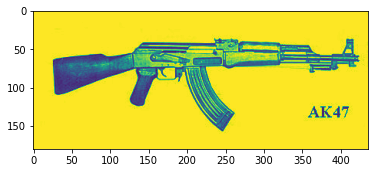

In [ ]:
plt.imshow(caltech256[15][0].permute(1, 2, 0))

In [ ]:
three_channel = torch.empty(3,224,224).shape
categories_to_keep = range(20)

n_samples_orig = len(caltech256)
print('Number of samples in original set: {}'.format(n_samples_orig))

valid_3_channel_samples = np.full((n_samples_orig,), True)
samples_with_categories_to_keep = np.full((n_samples_orig,), True)
for i in range(len(caltech256)):
  valid_3_channel_samples = caltech256[i][0].shape == three_channel
  samples_with_categories_to_keep = caltech256[i][1] in categories_to_keep

samples_to_keep = valid_3_channel_samples and samples_with_categories_to_keep
n_samples = samples_to_keep.sum()

print('Number of samples in reduced set: {}'.format(n_samples))

Number of samples in original set: 30607


AttributeError: ignored

Randomly split the dataset into a training and a validation set with ratios 0.7/0.3.

In [ ]:
caltech256_train, caltech256_test = random_split(caltech256, [0.7,0.3])
print('Created training dataset containing {} datapoints'.format(len(caltech256_train)))
print('Created test dataset containing {} datapoints'.format(len(caltech256_test)))

# Importing Cifar 10

In [26]:
cifar10_train = datasets.CIFAR10(
    root="data",
    download=True,
    train = True,
    transform=preprocess
)
print('CIFAR10 trainingset contains {} datapoints'.format(len(cifar10_train)))

cifar10_test = datasets.CIFAR10(
    root="data",
    download=True,
    train = False,
    transform=preprocess
)
print('CIFAR10 testset contains {} datapoints'.format(len(cifar10_test)))

Files already downloaded and verified
CIFAR10 trainingset contains 50000 datapoints
Files already downloaded and verified
CIFAR10 testset contains 10000 datapoints


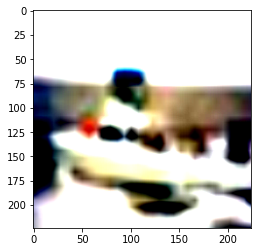

In [27]:
plt.imshow(cifar10_train[353][0].permute(1, 2, 0))

In [28]:
print(cifar10_train)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [38]:
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Split dataset and create dataloaders

Choose a dataset on which to finetune the model on.

In [30]:
train_data = cifar10_train
test_data = cifar10_test

Check the number of classes contained in the dataset

In [39]:
num_classes = len(train_data.classes)

Set some parameters for the training.

In [40]:
batch_size = 16
num_epochs = 15

Create the dataloaders.

In [41]:
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print('Created training dataloader containing {} batches'.format(len(train_dataloader)))
print('Created test dataloader containing {} batches'.format(len(test_dataloader)))

Created training dataloader containing 3125 batches
Created test dataloader containing 625 batches


## Initializing the network 

In [42]:
resnet.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In the case that we are feature extracting, we want to freeze all but a few layers (here all expect for the last layer)

In [43]:
feature_extract = True
if feature_extract:
  for param in resnet.parameters():
    param.requires_grad = False

Extract the number of classes in the Caltech256 dataset. 

Adapt resnet to the target task by changing the last fully connected layer to the required number of outputs (and initializing the weights in the process). The last layer will hereby have 'requires_grad=True'. This is called feature extraction.

In [44]:
print('Previous resnet fully connnected layer')
print(resnet.fc)
print('num of classes: {}'.format(num_classes))
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
print('New resnet fully connnected layer')
print(resnet.fc)

Previous resnet fully connnected layer
Linear(in_features=2048, out_features=1000, bias=True)
num of classes: 10
New resnet fully connnected layer
Linear(in_features=2048, out_features=10, bias=True)


Collect all parameters that are to be updated.

In [45]:
params_to_update = resnet.parameters
print('Parameters to be updated')
if feature_extract:
    params_to_update = []
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Parameters to be updated
	 fc.weight
	 fc.bias


Send the model to the device.

In [46]:
resnet = resnet.to(device)

Checke ob es die Input fehlerhaft sind.

In [ ]:
i = 0
for inputs, labels in train_dataloader:
  continue
  # print(i)
  # i = i+1
  # inputs = inputs.to(device)
  # labels = labels.to(device)
  # outputs = resnet(inputs)
  # print(outputs)
  # print(outputs.shape)
  # print(outputs.argmax(dim=1).shape)
  # if i == 3:
  #   break

Set the optimizer to be used for the training. Here we use either SGD, Adam or AdamW.

In [52]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0.1,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
optimizer = torch.optim.SGD(params_to_update, **sgd_parameters)

# adam_parameters = {
#     'lr':1e-3,            # 0.001
#     'betas':(0.9, 0.999), # (0.9, 0.999)
#     'eps':1e-08,          # 1e-08
#     'weight_decay':0      # 0
# }
# optimizer = torch.optim.Adam(params_to_update, **adam_parameters) # Adam
# optimizer = torch.optim.AdamW(params_to_update, **adam_parameters) # AdamW

Set the loss function.

In [53]:
label_smoothing = 0
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

Set the learning rate scheduler.

In [ ]:
# learning_rate_to_zero_in_number_of_epochs = 9999999
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=learning_rate_to_zero_in_number_of_epochs)

Helper function for training.

In [67]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_train_batches = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)

                    preds = outputs.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if batch % 100 == 0:
                          print('step {:4d}/{}'.format(batch,n_train_batches))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Start training of the model.


In [ ]:
resnet_finetuned, hist = train_model(resnet,
                                     {'train':train_dataloader,
                                      'val':test_dataloader},
                                     loss_fn,
                                     optimizer,
                                     num_epochs=num_epochs)

Epoch 0/14
----------
step    0/3125
step  100/3125
step  200/3125
step  300/3125
step  400/3125
step  500/3125
step  600/3125
step  700/3125
step  800/3125
step  900/3125
step 1000/3125
step 1100/3125
step 1200/3125
step 1300/3125
step 1400/3125
step 1500/3125
step 1600/3125
step 1700/3125
step 1800/3125
step 1900/3125
step 2000/3125
step 2100/3125
step 2200/3125
step 2300/3125
step 2400/3125
step 2500/3125
step 2600/3125
step 2700/3125
step 2800/3125
step 2900/3125
step 3000/3125
step 3100/3125
train Loss: 1.1879 Acc: 0.6761
val Loss: 1.0368 Acc: 0.7225

Epoch 1/14
----------
step    0/3125
step  100/3125
step  200/3125
step  300/3125
step  400/3125
step  500/3125
step  600/3125
step  700/3125
step  800/3125
step  900/3125
step 1000/3125
step 1100/3125
step 1200/3125
step 1300/3125
step 1400/3125
step 1500/3125
step 1600/3125
step 1700/3125
step 1800/3125
step 1900/3125
step 2000/3125
step 2100/3125
step 2200/3125
step 2300/3125
step 2400/3125
step 2500/3125
step 2600/3125
step 2700/